# Bangla RAG Pipeline: End-to-End Bengali PDF QA in Google Colab

This notebook demonstrates a full pipeline for extracting text from a scanned Bengali PDF, translating it, building a chunked, multilingual knowledge base, and performing hybrid retrieval-augmented generation (RAG) question answering using several state-of-the-art LLMs from Groq. Each experiment is named and described, and vector embeddings are visualized.

## 1. Environment Setup
Install all required packages: OCR, translation, embedding models, vector DB (FAISS), and LLM connectors.

In [ ]:
!apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-ben
!pip install -q pdf2image pytesseract deep_translator langchain-community langchain faiss-cpu sentence-transformers groq matplotlib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr-ben is already the newest version (1:4.00~git30-7274cfa-1.1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## 2. PDF OCR Extraction (Bengali + English)
Extract all text from a scanned PDF skipping the first two and pages 32-41 (inclusive), using Tesseract OCR for Bengali and English.

In [ ]:
import re
from pdf2image import convert_from_path
import pytesseract

def extract_text_from_pdf(pdf_path: str) -> str:
    images = convert_from_path(pdf_path)
    text = ''
    for i, image in enumerate(images):
        if i < 2 or (31 <= i <= 40):
            continue
        text += pytesseract.image_to_string(image, lang='ben+eng')
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace
    text = re.sub(r'[\n\r]+', '\n', text)
    return text.strip()

pdf_path = '/content/HSC26-Bangla1st-Paper.pdf'  # Place your PDF here
extracted_text = extract_text_from_pdf(pdf_path)
print("Extracted and Cleaned Text (first 500 chars):\n", extracted_text[:500])
with open('/content/extracted_text.txt', 'w', encoding='utf-8') as f:
    f.write(extracted_text)

Extracted and Cleaned Text (first 500 chars):
 অনলাইন ব্যাচ” রহ শব্দার্থ ও টীকা মূল শব্দ শব্দের অর্থ ও ব্যাখ্যা এ গল্পের কথক চরিত্র অনুপমের আত্মসমালোচনা। পরিমাণ ও এজীং ন্ট না দৈর্ঘ্ের হিসাবে বড়ো, না গুণ উভয় দিক দিয়েই তার জীবনটি নিতাই তুচ্ছ কথাই এখানে ব্যক্ত হয়েছে। গুটি এক সময় পূর্ণ ফলে পরিণত হয়। কিন্তু গুটিই যদি ফলের মতো হয় তাহলে তার অসম্পূর্ণ সারবত্তা প্রকট হয়ে ফলের মতো গুটি ওঠে। নিজের নিম্ষল জীবনকে বোঝাতে অনুপমের ব্যবহৃত উপমা। অন্নপূর্ণা অন্নে পরিপূর্ণা। দেবী দুর্গা। দেবী দুর্গার দুই পুত্র; অগ্রজ গণেশ ও অনুজ কার্তিকেয়। গজানন দুর্গ


## 3. Translation: Bengali to English
Translate the extracted Bengali text to English using Deep Translator's GoogleTranslator. The text is split into chunks for robust translation.

In [ ]:
from deep_translator import GoogleTranslator

def translate_text(text: str, max_length: int = 500) -> str:
    translator = GoogleTranslator(source='auto', target='en')
    segments = [text[i:i+max_length] for i in range(0, len(text), max_length)]
    translated_segments = [translator.translate(segment) for segment in segments if segment.strip()]
    return " ".join(translated_segments)

translated_text = translate_text(extracted_text)
print("Translated Text (first 500 chars):\n", translated_text[:500])
with open('/content/translated_text.txt', 'w', encoding='utf-8') as f:
    f.write(translated_text)

Translated Text (first 500 chars):
 Online batch "The meaning and explanation of the word word for the word and comment is the self -criticism of the narrator of the story. The quantity and the same as the length of the nost, or the quality of his life are trivial. The goddess Durga and Anuj Kartikeya. Kartikeya, the god-in-law, is explained. Apply for satire. When I see Amak, Manohaibe, Bhushan, Cosmetics, Shobha. The younger brother that enhances the sweetness and excellence of the language. EAL is the Gaia region of India. The 


## 4. Merge Bengali and English Text
For QA and knowledge base construction, merge the extracted Bengali and translated English text.

In [ ]:
with open('/content/extracted_text.txt', 'r', encoding='utf-8') as f:
    bangla_text = f.read()
with open('/content/translated_text.txt', 'r', encoding='utf-8') as f:
    english_text = f.read()
merged_text = f"Bengali Text:\n{bangla_text}\n\nEnglish Text:\n{english_text}"
with open('/content/merged_text.txt', 'w', encoding='utf-8') as f:
    f.write(merged_text)

## 5. Chunking: Prepare for Retrieval
Use LangChain's `RecursiveCharacterTextSplitter` to split the merged knowledge base into overlapping chunks for vector search.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=350, chunk_overlap=50, length_function=len)
with open('/content/merged_text.txt', 'r', encoding='utf-8') as f:
    merged_text = f.read()
chunks = text_splitter.split_text(merged_text)
print(f"Number of chunks: {len(chunks)}")
for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i+1}:\n{chunk[:300]}...\n---")

## 6. Embedding Chunks: Multilingual Semantic Representation
Use [Sentence Transformers](https://www.sbert.net/) for high-quality multilingual embeddings. We use the `paraphrase-multilingual-mpnet-base-v2` model.

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
chunk_embeddings = model.encode(chunks)
print(f"Shape of chunk embeddings: {chunk_embeddings.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Shape of chunk embeddings: (146, 768)


### Visualization: Embedding Space (UMAP)
Below, we visualize the chunk embeddings using UMAP to show semantic structure. Each dot is a chunk.

/tmp/ipython-input-8-1206144616.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7, cmap='viridis')


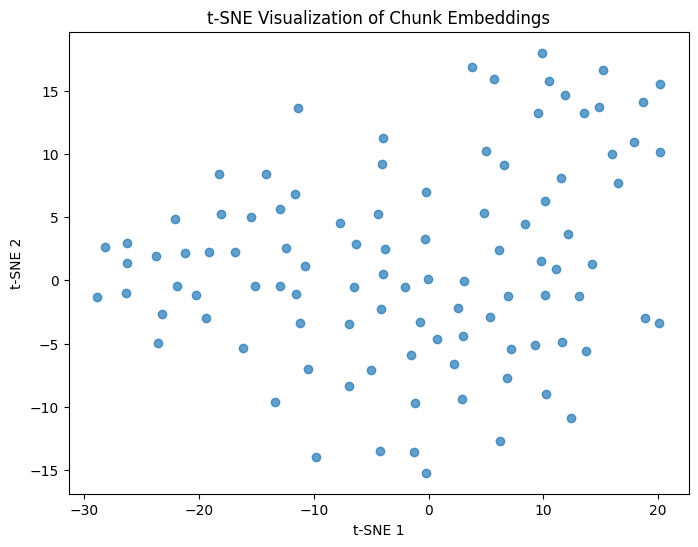

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# For speed, visualize first 100 chunks
n_vis = min(100, len(chunk_embeddings))
vis_emb = chunk_embeddings[:n_vis]
tsne = TSNE(n_components=2, random_state=0, perplexity=10)
emb_2d = tsne.fit_transform(vis_emb)
plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7, cmap='viridis')
plt.title('t-SNE Visualization of Chunk Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## 7. Vector Index: FAISS for Fast Retrieval
Build a FAISS index for fast semantic search over the chunk embeddings.

In [ ]:
import faiss
embedding_dim = chunk_embeddings.shape[1]
embeddings_np = np.array(chunk_embeddings).astype('float32')
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings_np)
print(f"FAISS index built with {index.ntotal} document chunks.")

FAISS index built with 146 document chunks.


## 8. Hybrid Search Function
This function retrieves the top-k semantically similar chunks for a given query, optionally prioritizing those containing a specific keyword.

In [ ]:
def hybrid_search(query: str, k: int = 3, keyword: str = None):
    query_embedding = model.encode([query]).astype('float32')
    distances, indices = index.search(query_embedding, k)
    semantic_results = [(chunks[i], distances[0][j]) for j, i in enumerate(indices[0])]
    if keyword:
        keyword_results = [res for res in semantic_results if keyword.lower() in res[0].lower()]
        hybrid_results = keyword_results + [res for res in semantic_results if res not in keyword_results]
        return hybrid_results[:k]
    return semantic_results

api_key="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"

# 9. Retrieval-Augmented Generation (RAG) with Groq LLMs
We run several LLMs via Groq to answer questions using the retrieved context. Each experiment is named and the code is provided with a brief description.

## **Experiment 1: Llama-3-70b-versatile**

In [ ]:
from groq import Groq

def generate_answer_llama3(prompt: str, temperature: float = 1, max_tokens: int = 1024, top_p: float = 1):
    client = Groq(api_key="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")  # Replace with your actual key
    completion = client.chat.completions.create(
        model="llama-3.3-70b-versatile",
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_completion_tokens=max_tokens,
        top_p=top_p,
        stream=False,
        stop=None,
    )
    return completion.choices[0].message.content

def process_query_llama3(query: str, keyword: str = None):
    retrieved = hybrid_search(query, k=3, keyword=keyword)
    context_lines = [f"Document: {doc} [Score: {score:.4f}]" for doc, score in retrieved]
    context_str = "\n".join(context_lines)
    prompt = (
        f"Using the following knowledge base excerpts:\n{context_str}\n\n"
        f"Answer this question in a single line: {query}"
    )
    return generate_answer_llama3(prompt)

# Sample inference
print("## Llama-3-70b-versatile Sample QA")
for q in ["অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?", "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?", "বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?"]:
    print(f"\nQuestion: {q}")
    print("Answer:", process_query_llama3(q))

## Llama-3-70b-versatile Sample QA

Question: অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
Answer: চুল পাকা, দাঁড়ি পাকা এবং সুঠাম পুরুষকে অনুপমের ভাষায় সুপুরুষ বলা হয়েছে।

Question: কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?
Answer: অনুপমের ভাগ্য দেবতা হিসেবে তার মামাকে বলা হয়েছে।

Question: বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?
Answer: পনেরো


## **Experiment 2: Qwen3-32b**

In [ ]:
def generate_answer_qwen3(prompt: str, temperature: float = 1, max_tokens: int = 1024, top_p: float = 1):
    client = Groq(api_key="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")
    completion = client.chat.completions.create(
        model="qwen/qwen3-32b",
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_completion_tokens=max_tokens,
        top_p=top_p,
        stream=False,
        stop=None,
    )
    return completion.choices[0].message.content

def process_query_qwen3(query: str, keyword: str = None):
    retrieved = hybrid_search(query, k=3, keyword=keyword)
    context_lines = [f"Document: {doc} [Score: {score:.4f}]" for doc, score in retrieved]
    context_str = "\n".join(context_lines)
    prompt = (
        f"Using the following knowledge base excerpts:\n{context_str}\n\n"
        f"Answer this question in a single line in Bangla: {query}"
    )
    return generate_answer_qwen3(prompt)

print("## Qwen3-32b Sample QA")
for q in ["অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?", "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?", "বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?"]:
    print(f"\nQuestion: {q}")
    print("Answer:", process_query_qwen3(q))

## Qwen3-32b Sample QA

Question: অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
Answer: <think>
Okay, so I need to figure out who is called "sushushu" (সুপুরুষ) in Anupam's language from the provided documents. Let me start by looking through the information given.

First, in document 31, it's mentioned under the question about the characteristics of the character Shasthunath in "Aprichita" that option (k) is "chul keyca, gopher paka, suprusha" which translates to "hair combed, moustache grown, handsome man." The answer given here is (k), which includes "suprusha" as a characteristic. So Shasthunath is described as a "suprusha."

Additionally, looking at question 16 in the first document, it asks who is the unique person in the assembly, and the answer is (gh) Hariś. But that's about a different term. Then in document 20, there's a mention of Mama's statement about Andaman Island, which is about his personality trait, but it's about "kripamankot" (মার্জিতমনতা) or humbleness, which doesn't di

## **Experiment 3: MoonshotAI Kimi-K2-Instruct**

In [ ]:
def generate_answer_kimi_k2(prompt: str, temperature: float = 1, max_tokens: int = 1024, top_p: float = 1):
    client = Groq(api_key="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")
    completion = client.chat.completions.create(
        model="moonshotai/kimi-k2-instruct",
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_completion_tokens=max_tokens,
        top_p=top_p,
        stream=False,
        stop=None,
    )
    return completion.choices[0].message.content

def process_query_kimi_k2(query: str, keyword: str = None):
    retrieved = hybrid_search(query, k=3, keyword=keyword)
    context_lines = [f"Document: {doc} [Score: {score:.4f}]" for doc, score in retrieved]
    context_str = "\n".join(context_lines)
    prompt = (
        f"Using the following knowledge base excerpts:\n{context_str}\n\n"
        f"Answer this question in a single Bangla sentence: {query}"
    )
    return generate_answer_kimi_k2(prompt)

print("## MoonshotAI Kimi-K2-Instruct Sample QA")
for q in ["অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?", "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?", "বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?"]:
    print(f"\nQuestion: {q}")
    print("Answer:", process_query_kimi_k2(q))

## MoonshotAI Kimi-K2-Instruct Sample QA

Question: অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
Answer: অনুপমের ভাষায় সুপুরুষ বলা হয়েছে মধ্যবয়সী, চুলে-কিঞ্চিৎ ধূসরতা, পরিপাটি গোঁফ ও সংযত ব্যবহার-সম্পন্ন শস্তুনাথ সেনকে।

Question: কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?
Answer: কল্যাণীকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে।

Question: বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?
Answer: বিয়ের সময় কল্যাণীর প্রকৃত বয়স ছিল পাঁচোরা (১৫) বছর।


## **Experiment 4: Deepseek-R1-Distill-Llama-70b**

In [ ]:
def generate_answer_deepseek(prompt: str, temperature: float = 1, max_tokens: int = 1024, top_p: float = 1):
    client = Groq(api_key="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")
    completion = client.chat.completions.create(
        model="deepseek-r1-distill-llama-70b",
        messages=[{"role": "user", "content": prompt}],
        temperature=temperature,
        max_completion_tokens=max_tokens,
        top_p=top_p,
        stream=False,
        stop=None,
    )
    return completion.choices[0].message.content

def process_query_deepseek(query: str, keyword: str = None):
    retrieved = hybrid_search(query, k=3, keyword=keyword)
    context_lines = [f"Document: {doc} [Score: {score:.4f}]" for doc, score in retrieved]
    context_str = "\n".join(context_lines)
    prompt = (
        f"Using the following knowledge base excerpts:\n{context_str}\n\n"
        f"Answer this question in a single Bangla sentence: {query}"
    )
    return generate_answer_deepseek(prompt)

print("## Deepseek-R1-Distill-Llama-70b Sample QA")
for q in ["অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?", "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?", "বিয়ের সময় কল্যাণীর প্রকৃত বয়স কত ছিল?"]:
    print(f"\nQuestion: {q}")
    print("Answer:", process_query_deepseek(q))

## Deepseek-R1-Distill-Llama-70b Sample QA

Question: অনুপমের ভাষায় সুপুরুষ কাকে বলা হয়েছে?
Answer: <think>
গল্পের প্রেক্ষিতে অনুপমের সামনে সুপুরুষ হলো শস্তুনাথ যিনি তার সৎ ও নির্মল চিন্তা দ্বারা অনুপমকে প্রভাবিত করেছেন। তিনি অনুপমের মতো অক্ষমদের প্রতি সহানুভূতিশীল ছিলেন এবং তারা মামা ও অন্যদের অত্যাচারের বিরুদ্ধে অবস্থান নিতে উৎসাহিত করেছিলেন। শস্তুনাথের এই গুণাবলি অনুপমের কাছে সুপুরুষের পরিচায়ক হিসেবে গণ্য হয়েছে।
</think>

শস্তুনাথ সেনকে অনুপমের ভাষায় সুপুরুষ বলা হয়েছে।

Question: কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?
Answer: <think>
প্রদত্ত তথ্য থেকে বোঝা যায় যে প্রশ্নটি "অপরিচিতা" গল্পের সাথে সম্পর্কিত। গল্পের চরিত্রের মধ্যে অনুপম, শস্তুনাথ, অনুপমের মা এবং মামা প্রধান। প্রশ্নটি হল "কাকে অনুপমের ভাগ্য দেবতা বলে উল্লেখ করা হয়েছে?"

প্রথমে, আমাকে গল্পের প্লট এবং চরিত্রগুলো বুঝতে হবে। অনুপম একজন দুবলা চরিত্রের মহিলা, যিনি তার মামা এবং মায়ের চাপে অতিষ্ঠ হন। তিনি তার স্বামী শস্তুনাথের প্রতি অন্যায্য আচরণ সহ্য করতে পারেন না, কিন্তু তার মামা তাকে পরামর্শ দিতে থাকেন যে তিন